This assignment covers data preprocessing with datasets contaning overlapping but different features. The goal is to augment, merge, and enhance the data while ensuring consistency in a machine learning pipeline.

TASK 1: Data Augmentation on CSV Files

In [2]:
# Loading the dataset
import pandas as pd

file_path = '../initial_dataset/customer_transactions.csv'

data = pd.read_csv(file_path)

In [3]:
data

,customer_id_legacy,transaction_id,purchase_amount,purchase_date,product_category,customer_rating
0,151,1001,408,2024-01-01,Sports,2.3
1,192,1002,332,2024-01-02,Electronics,4.2
2,114,1003,442,2024-01-03,Electronics,2.1
3,171,1004,256,2024-01-04,Clothing,2.8
4,160,1005,64,2024-01-05,Clothing,1.3
...,...,...,...,...,...,...
145,102,1146,88,2024-05-25,Sports,2.7
146,100,1147,387,2024-05-26,Books,4.6
147,104,1148,409,2024-05-27,Clothing,1.4
148,189,1149,178,2024-05-28,Sports,3.0


In [4]:
print(data.isnull().sum())

customer_id_legacy     0
transaction_id         0
purchase_amount        0
purchase_date          0
product_category       0
customer_rating       10
dtype: int64


In [ ]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import joblib

target_column = "customer_rating"
features = data.drop(columns=[target_column])  # Excluding target


data['purchase_date'] = pd.to_datetime(data['purchase_date']).view('int64') / 10**9
# one hot encoding for product category
data = pd.get_dummies(data, columns=['product_category'])

# Create a dataset with missing values artificially
data_missing = data.copy()
mask = np.random.rand(len(data_missing)) < 0.1  # 10% missing values
data_missing[target_column] = data_missing[target_column].mask(mask)

# Ground truth for evaluation (original values before masking)
y_true = data[target_column][mask]

# Different imputation strategies
strategies = ['mean', 'median', 'most_frequent', 'random_forest']
results = {}

# Impute and evaluate each strategy
for strategy in strategies:
    print(f"\nEvaluating {strategy} imputation...")
    data_imputed = data_missing.copy()

    if strategy == 'random_forest':
        # Predictive modeling with Random Forest
        train_data = data_imputed[data_imputed[target_column].notnull()]
        test_data = data_imputed[data_imputed[target_column].isnull()]
        
        X_train = train_data.drop(columns=[target_column])
        y_train = train_data[target_column]
        X_test = test_data.drop(columns=[target_column])

        rf_imputer = RandomForestRegressor(n_estimators=100, random_state=42)
        rf_imputer.fit(X_train, y_train)
        imputed_values = rf_imputer.predict(X_test)
        
        data_imputed.loc[data_imputed[target_column].isnull(), target_column] = imputed_values
    else:
        # Simple imputation (mean, median, mode)
        imputer = SimpleImputer(strategy=strategy)
        data_imputed[[target_column]] = imputer.fit_transform(data_imputed[[target_column]])

    # Evaluate imputation performance using MSE against ground truth
    y_pred = data_imputed[target_column][mask]
    mse = np.mean((y_true - y_pred) ** 2)
    results[strategy] = mse
    print(f"{strategy.capitalize()} MSE: {mse:.4f}")

    # Train a model to check predictive power (R²)
    X_train, X_test, y_train, y_test = train_test_split(
        data_imputed.drop(columns=[target_column]), data_imputed[target_column], 
        test_size=0.2, random_state=42
    )
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"{strategy.capitalize()} R²: {scores.mean():.4f}")

# Find the best imputation method
best_strategy = min(results, key=results.get)  # Lower MSE is better
print(f"\nBest Imputation Method: {best_strategy} with MSE: {results[best_strategy]:.4f}")

# Save the best imputer model
if best_strategy == 'random_forest':
    joblib.dump(rf_imputer, "best_rf_imputer.pkl")
    print("Best Random Forest imputer saved as 'best_rf_imputer.pkl'!")
else:
    best_imputer = SimpleImputer(strategy=best_strategy)
    best_imputer.fit(data[[target_column]])  # Train on original data
    joblib.dump(best_imputer, "/models/best_imputer.pkl")
    print("Best imputer model saved as 'best_imputer.pkl'!")

C:\Users\HOSA.LTD\AppData\Local\Temp\ipykernel_17640\1977150796.py:14: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  data['purchase_date'] = pd.to_datetime(data['purchase_date']).view('int64') / 10**9



Evaluating mean imputation...
Mean MSE: 1.2370
Mean R²: -0.2200

Evaluating median imputation...
Median MSE: 1.2339
Median R²: -0.2365

Evaluating most_frequent imputation...
Most_frequent MSE: 4.2939
Most_frequent R²: -0.0856

Evaluating random_forest imputation...
Random_forest MSE: 1.0427
Random_forest R²: -0.0722

Best Imputation Method: random_forest with MSE: 1.0427
Best Random Forest imputer saved as 'best_rf_imputer.pkl'!


In [7]:
import joblib

# Load the saved imputer model
best_imputer = joblib.load("../models/best_imputer.pkl")

# Apply the imputer to fill missing values
data = data.copy()  # Make a copy of the original data
data[['customer_rating']] = best_imputer.transform(data[['customer_rating']])

print(data.isnull().sum())


customer_id_legacy              0
transaction_id                  0
purchase_amount                 0
purchase_date                   0
customer_rating                 0
product_category_Books          0
product_category_Clothing       0
product_category_Electronics    0
product_category_Groceries      0
product_category_Sports         0
dtype: int64


In [ ]:
# Data Augmentation Strategies

import numpy as np
from imblearn.over_sampling import SMOTE
from scipy.stats import skew

data['purchase_date'] = pd.to_datetime(data['purchase_date']).view('int64') / 10**9
# numerical columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
numeric_cols = [col for col in numeric_cols if col not in ['customer_id_legacy', 'transaction_id']]

# Synthetic data generation using random noise and SMOTE

# Random noise
print("Applying random noise to numerical transaction values...")
for col in numeric_cols:
    noise = np.random.normal(0, 0.05 * data[col].std(), size=data[col].shape)  # 5% of std as noise
    data[col] = data[col] + noise
print("Random noise applied.")

data['high_value_customer'] = (data['customer_rating'] > 2.5).astype(int)
print("Created synthetic target 'high_value_customer' based on customer_rating > 2.5.")

# Use SMOTE to balance the dataset
print("Applying SMOTE to balance the dataset...")
X = data.drop(columns=['high_value_customer', 'customer_id_legacy', 'transaction_id'])
y = data['high_value_customer']
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reconstruct the dataset after SMOTE
data_resampled = pd.DataFrame(X_resampled, columns=X.columns)
data_resampled['high_value_customer'] = y_resampled

# Decode 'product_category' back to its original form
category_cols = [col for col in data_resampled.columns if col.startswith('product_')]
if not category_cols:
    raise ValueError("No product_ columns found in data_resampled.")

# Find category with highest value (one-hot encoded column)
category_labels = data_resampled[category_cols].idxmax(axis=1)
category_labels = category_labels.str.replace('product_', '', regex=True)

# Assign back to dataset
data_resampled['product_category'] = category_labels
data_resampled = data_resampled.drop(columns=category_cols)

# Add back 'customer_id_legacy' and 'transaction_id' (assign placeholders for new rows)
data_resampled['customer_id_legacy'] = -1 
data_resampled['transaction_id'] = range(len(data_resampled))
data = data_resampled[['customer_id_legacy', 'transaction_id', 'purchase_amount', 
                       'purchase_date', 'product_category', 'customer_rating', 'high_value_customer']]
print("SMOTE applied. New shape:", data.shape)

# Feature value transformation
print("\nApplying log transformation to skewed numerical data...")
for col in numeric_cols:
    if skew(data[col].dropna()) > 1:  # Check skewness
        data[col] = np.log1p(data[col].clip(lower=0))
        print(f"Log transformation applied to {col}")
    else:
        print(f"No transformation needed for {col} (skewness < 1)")


# Data expansion
print("\nGenerating synthetic transactions...")
new_transactions = data.sample(frac=0.2, random_state=42)  # 20% of original data as synthetic
for col in numeric_cols:
    new_transactions[col] = new_transactions[col] * (1 + np.random.uniform(-0.1, 0.1))  # ±10% variation
data_augmented = pd.concat([data, new_transactions], ignore_index=True)
print("Synthetic transactions added. New shape:", data_augmented.shape)


data_augmented = data_augmented.drop(columns=['high_value_customer'])

Applying random noise to numerical transaction values...
Random noise applied.
Created synthetic target 'high_value_customer' based on customer_rating > 2.5.
Applying SMOTE to balance the dataset...
SMOTE applied. New shape: (198, 7)

Applying log transformation to skewed numerical data...
No transformation needed for purchase_amount (skewness < 1)
No transformation needed for purchase_date (skewness < 1)
No transformation needed for customer_rating (skewness < 1)

Generating synthetic transactions...
Synthetic transactions added. New shape: (238, 7)


C:\Users\HOSA.LTD\AppData\Local\Temp\ipykernel_17640\1243049603.py:7: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  data['purchase_date'] = pd.to_datetime(data['purchase_date']).view('int64') / 10**9
c:\Users\HOSA.LTD\data_preprocessing\venv\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [9]:
# Save the augmented dataset

print("\nExporting augmented dataset...")
data_augmented.to_csv('../augmented_dataset/customer_transactions_augmented.csv', index=False)
print("Augmented dataset saved as 'customer_transactions_augmented.csv'.")


Exporting augmented dataset...
Augmented dataset saved as 'customer_transactions_augmented.csv'.


In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_regression
from scipy.stats import skew

# Load the augmented dataset
data = pd.read_csv('../augmented_dataset/customer_transactions_augmented.csv')
print(data.shape)

(238, 6)


In [12]:
# Data integrity checks

# Check for duplicates
duplicates = data.duplicated().sum()
print(f"Duplicate rows: {duplicates}")

if duplicates > 0:
    data = data.drop_duplicates()
    print(data.shape)



Duplicate rows: 0


In [13]:
# Ensure categorical values are correctly mapped
category_columns = data.select_dtypes(include=['object']).columns
for col in category_columns:
    print(f"Unique values in {col}: {data[col].unique()}")
    if data[col].isnull().sum() > 0:
        print(f"Missing values in {col}: {data[col].isnull().sum()}")

Unique values in product_category: ['category_Sports' 'category_Electronics' 'category_Clothing'
 'category_Groceries' 'category_Books']


In [14]:
# Validate customer transactions
invalid_ids = data['customer_id_legacy'].isnull().sum()
print(f"Invalid customer IDs: {invalid_ids}")

# Drop rows with missing customer IDs
if invalid_ids > 0:
    data = data.dropna(subset=['customer_id_legacy'])
    print(data.shape)

Invalid customer IDs: 0


       customer_id_legacy  transaction_id  ...  purchase_date  customer_rating
count               238.0      238.000000  ...     238.000000       238.000000
mean                 -1.0       98.840336  ...       1.699453         2.665423
std                   0.0       56.757160  ...       0.024933         1.155376
min                  -1.0        0.000000  ...       1.638503         1.005941
25%                  -1.0       51.250000  ...       1.705652         1.538808
50%                  -1.0       99.500000  ...       1.709452         2.522171
75%                  -1.0      147.750000  ...       1.712752         3.676197
max                  -1.0      197.000000  ...       1.717063         5.036480

[8 rows x 5 columns]


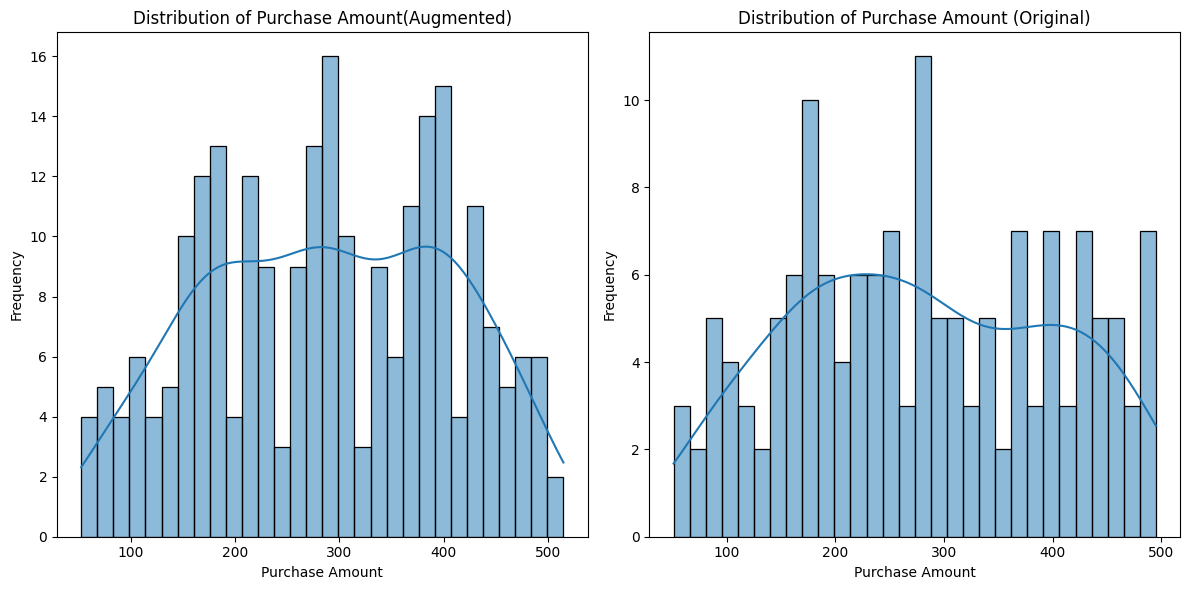

In [15]:
# Statistical summary
numeric_cols = data.select_dtypes(include=[np.number]).columns
print(data[numeric_cols].describe())

# Data visualization
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(data['purchase_amount'], bins=30, kde=True)
plt.title("Distribution of Purchase Amount(Augmented)")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")

# original dataset
original_data = pd.read_csv('../initial_dataset/customer_transactions.csv')
plt.subplot(1, 2, 2)
sns.histplot(original_data['purchase_amount'], kde=True, bins=30)
plt.title("Distribution of Purchase Amount (Original)")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()
